In [76]:
from __future__ import unicode_literals
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import jieba
import math
import time
import json 
import re
import os
import datetime
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [77]:
# 数据说明
# 数据集来自百科问答，我会将其整理成10个大类。
# valid文件很小可以用来测试代码的准确性，
# 跑通了再用train替换valid来看实际效果。


In [78]:
# 数据预处理（删除很短的条目，分词）

# 仅保存一下10个数量较多的类
categorys =['烦恼', '游戏', '商业', '娱乐', '生活', '教育', '健康', '电脑', '体育', '汽车']

#根据停用文件构建 停用字典
def MakeWordsSet(words_file):
    words_set = set()
    with open(words_file, 'r', encoding='utf-8') as fp:
        for line in fp.readlines():
            word = line.strip()
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

#这个事停用词表，这里需要说明一下。该停用词表下载自网络，我在分析了baike_qa_train的词频后，在停用词表里添加了数字以及“一个”等停用词。
stopwords_file = 'data/cn_stopwords.txt'
stopwords_set = MakeWordsSet(stopwords_file)

#下面这三行，先用valid进行测试，因为比较快。没问题了再用train
source = 'data/baike_qa_train.json' #源文件
middle = 'middle/baike_qa_train.json' #保存处理过的文件
csv = 'csv/baike_qa_train.csv' #转换为csv格式，用于之后训练

#处理原文件
with open(source,'r', encoding='utf-8') as f: 
     if os.path.exists(middle):
        os.remove(middle)
     with open(middle, 'a', encoding='utf-8') as ff: #这个是目标文件（训练集）
        for line in tqdm(f.readlines()):
            line_js = {}
            js = json.loads(line)
            cat = js['category'].split('-')[0].split('/')[0]
            if cat in categorys:
                string = js['title']+js['desc']+js['answer']
                line_js['cat'] = cat
                seg_list = jieba.cut(string)  # 结巴分词
                content =''
                for word in seg_list:
                    #清理字符串中的特殊字符、转移字符
                    word = re.sub(u"([^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a\u00A0])","",word)
                    if word == '' or (word in stopwords_set) :#去除停用词和空词
                        continue
                    else :
                        content += ',' + word
                if len(content[1:]) < 30: #删除过短的例子
                    continue
                line_js['review'] = content[1:]
                str = json.dumps(line_js, ensure_ascii=False)
                ff.write(str+'\n')
#将处理过的json转化为csv
with open(middle,'r', encoding='utf-8') as f: 
    a = []
    for line in tqdm(f.readlines()):
      js = json.loads(line)
      a.append(js)
    df = pd.DataFrame(a)
    print(df.info())
    df.to_csv(csv)

100%|██████████| 1227788/1227788 [00:06<00:00, 202139.56it/s]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227788 entries, 0 to 1227787
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   cat     1227788 non-null  object
 1   review  1227788 non-null  object
dtypes: object(2)
memory usage: 18.7+ MB
None


In [79]:
# 读取csv查看结构
df = pd.read_csv(csv)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227788 entries, 0 to 1227787
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1227788 non-null  int64 
 1   cat         1227788 non-null  object
 2   review      1227788 non-null  object
dtypes: int64(1), object(2)
memory usage: 28.1+ MB
None


,Unnamed: 0,cat,review
0,0,教育,"人站,地球,头朝下,感觉,地球,重力,作用,一直,指向,球心,头,远离,球心,回,感到,头朝"
1,1,娱乐,"baby,baby,辛巴,温顺,可爱,两个,小家伙,第一次,养狗,注意,求,指教,爱,勤,洗..."
2,2,娱乐,"请问,这起,交通事故,责任,居多,小车,摩托车,发生,事故,红绿灯,小车,摩托车,发生,事故..."
3,3,生活,"请教,很快,洗,干净,猪肠,方法,方法,先,清水,一下,食盐,反复,搓揉,肠,黏液,全,去掉..."
4,4,健康,"毛孔,粗大,脸上,长,豆豆,出,油,额头,鼻子,脸上,毛孔,脸上,长,豆豆,出,油,额头,鼻..."


Text(0.5, 0, '类目')

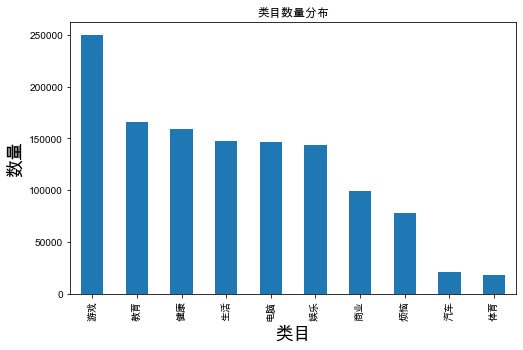

In [80]:
#查看大类情况
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目数量分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)

In [81]:
#将cat类转换成id，这样便于提升训练速度。
#把分词个分隔符用空格替换逗号，便于之后训练
df['cat_id'] = df['cat'].factorize()[0]
cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
df['cut_review'] = [i.replace(',',' ') for i in df['review']] 
df=df[['cat','cat_id','cut_review']]
df.sample(10)

,cat,cat_id,cut_review
1005275,娱乐,1,经典歌曲 需要 知道 需要 知道 团结 力量 共产党 新 中国 松花江 东方红 南泥湾 十送...
64186,生活,2,淄博 哪有卖 脱毛膏 质量 大约 钱 100 元 以下 淄博 哪有卖 膏 质量 大约 钱 1...
396286,商业,5,工资 问题 请问 低 核算 要算 工资 总 人数 税收 关系 请问 低 核算 要算 工资 总...
753075,生活,2,米酒 醪糟 甜 西北 称为 醪糟 江南 称之为 甜 米酒 做成 做 甜 米酒 容器 干净 先...
542613,游戏,4,没收 宝箱 问题 请问 公告 新手 注册 前 天内 每天 请问 公告 新手 注册 前 天内 ...
1063984,游戏,4,梦幻 首饰 换取 梦幻 首饰 需要 材料 换得 知道 朋友 告诉 梦幻 需要 材料 换得 知...
1192760,游戏,4,订单 卖家 有用吗 RT 请问 卖家 交易 帐号 查看 定单 显 RT 请问 交易 帐号 查...
279386,烦恼,8,破 处女 以后 腿 会 变成 O 形 怎么回事 女朋友 初三 女朋友 初三 大腿 中间 成 ...
282964,电脑,6,知道 BAIDU 搜索 栏里 以前 搜过 东西 删除 打开 打开 BDU 网页 搜索 栏里 ...
558479,健康,3,痤疮 杆菌 厌氧菌 痤疮 丙酸 杆菌 一种 革兰 染色 阳性 厌氧短 杆菌 一种 细胞 寄生...


In [82]:
#词云的这段代码不知道为甚么跑不通，先不管了

# from collections import Counter
# from wordcloud import WordCloud
 
# def generate_wordcloud(tup):
#     wordcloud = WordCloud(background_color='white',
#                           font_path='simhei.ttf',
#                           max_words=50, max_font_size=40,
#                           random_state=42
#                          ).generate(str(tup))
#     return wordcloud
 
# cat_desc = dict()
# for cat in cat_id_df.cat.values: 
    
#     text = df.loc[df['cat']==cat, 'cut_review']
#     text = (' '.join(map(str,text))).split(' ')
#     cat_desc[cat]=text
    
# fig,axes = plt.subplots(5, 2, figsize=(30, 38))
# k=0
# for i in range(5):
#     for j in range(2):
#         cat = id_to_cat[k]
#         most100=Counter(cat_desc[cat]).most_common(100)
#         ax = axes[i, j]
#         ax.imshow(generate_wordcloud(most100), interpolation="bilinear")
#         ax.axis('off')
#         ax.set_title("{} Top 100".format(cat), fontsize=30)
#         k+=1

In [83]:
#接下来我要计算cut_review的 TF-IDF的特征值，TF-IDF（term frequency–inverse document frequency）是一种用于信息检索与数据挖掘的常用加权技术。TF意思是词频(Term Frequency)，IDF意思是逆文本频率指数(Inverse Document Frequency)。TF-IDF是在单词计数的基础上，降低了常用高频词的权重,增加罕见词的权重。因为罕见词更能表达文章的主题思想,比如在一篇文章中出现了“中国”和“卷积神经网络”两个词,那么后者将更能体现文章的主题思想,而前者是常见的高频词,它不能表达文章的主题思想。所以“卷积神经网络”的TF-IDF值要高于“中国”的TF-IDF值。这里我们会使用sklearn.feature_extraction.text.TfidfVectorizer方法来抽取文本的TF-IDF的特征值。这里我们使用了参数ngram_range=(1,2),这表示我们除了抽取评论中的每个词语外,还要抽取每个词相邻的词并组成一个“词语对”,如: 词1，词2，词3，词4，(词1，词2)，(词2,词3)，(词3，词4)。这样就扩展了我们特征集的数量,有了丰富的特征集才有可能提高我们分类文本的准确度。参数norm='l2',是一种数据标准划处理的方式,可以将数据限制在一点的范围内比如说(-1,1)
start = time.time()
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.cut_review)
labels = df.cat_id
end = time.time()
print(features.shape)
print(features)
print (end - start,'s')





(1227788, 38144079)
  (0, 18765825)	0.24257011186237162
  (0, 26741841)	0.24257011186237162
  (0, 34989237)	0.24257011186237162
  (0, 26741879)	0.24257011186237162
  (0, 20054254)	0.23570546843819332
  (0, 3439929)	0.23083492641763734
  (0, 7075823)	0.19363526867981215
  (0, 35781442)	0.1609613285408946
  (0, 13133373)	0.19102545237392546
  (0, 18810120)	0.2153218550795298
  (0, 14380333)	0.23570546843819332
  (0, 13131331)	0.24257011186237162
  (0, 6197346)	0.24257011186237162
  (0, 14380280)	0.1891211670634151
  (0, 18764645)	0.08959021266045707
  (0, 34988032)	0.11466413714352032
  (0, 26741780)	0.35513411201236983
  (0, 20053427)	0.1256876421596408
  (0, 3430827)	0.06712898335538295
  (0, 7074890)	0.06999995710495574
  (0, 35781256)	0.12769768696197875
  (0, 18803842)	0.06353372712392005
  (0, 14380314)	0.18011629874532692
  (0, 13129938)	0.21780873382901353
  (0, 6197300)	0.1667674839500827
  :	:
  (1227787, 30558602)	0.18981697443490952
  (1227787, 11729408)	0.18981697443490952
 

In [84]:
#我们看到我们的features的维度是(62773,657425),这里的62773表示我们总共有62773条评价数据，657425表示我们的特征数量这包括全部评论中的所有词语数+词语对(相邻两个单词的组合)的总数。下面我们要是卡方检验的方法来找出每个分类中关联度最大的两个词语和两个词语对。卡方检验是一种统计学的工具,用来检验数据的拟合度和关联度。在这里我们使用sklearn中的chi2方法。
# from sklearn.feature_selection import chi2 
# N = 2
# for cat, cat_id in sorted(cat_to_id.items()):
#     features_chi2 = chi2(features, labels == cat_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(cat))
#     print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


264.77224826812744 s


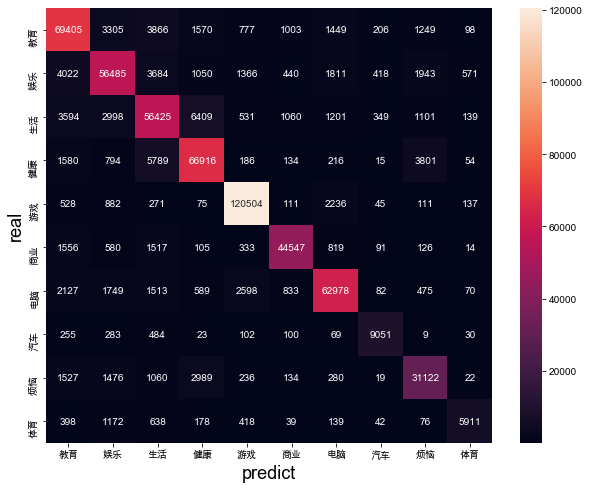

accuracy 0.8524989656194718
              precision    recall  f1-score   support

          教育       0.82      0.84      0.83     82928
          娱乐       0.81      0.79      0.80     71790
          生活       0.75      0.76      0.76     73807
          健康       0.84      0.84      0.84     79485
          游戏       0.95      0.96      0.96    124900
          商业       0.92      0.90      0.91     49688
          电脑       0.88      0.86      0.87     73014
          汽车       0.88      0.87      0.87     10406
          烦恼       0.78      0.80      0.79     38865
          体育       0.84      0.66      0.74      9011

    accuracy                           0.85    613894
   macro avg       0.85      0.83      0.84    613894
weighted avg       0.85      0.85      0.85    613894



In [85]:
#看一下准确率
start = time.time()
#训练模型
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.5, stratify=labels, random_state=0)
model.fit(X_train, y_train)
#预测
y_pred = model.predict(X_test)
#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
end = time.time()

print (end - start,'s')

plt.ylabel('real',fontsize=18)
plt.xlabel('predict',fontsize=18)
plt.show()

from sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat_id_df['cat'].values))


In [86]:
# 下面的部分，是我做的优化。目的是删除原始数据中的分类不合理的数据。
# 方法：训练十次（训练与测试集比例为7：3），统计每次预测错误的样本。如果一个样本在这10次统计中，错误两次以上，则在df中删除。
# 对原始数据进行清理
wrong = {}
for range1 in tqdm(range(10)):
    #训练模型
    model = LinearSVC()
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, stratify=labels, random_state=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #生成混淆矩阵
    conf_mat = confusion_matrix(y_test, y_pred)
    for predicted in cat_id_df.cat_id:
        for actual in cat_id_df.cat_id:
            if predicted != actual and conf_mat[actual, predicted] >= 6:
                indexs=df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]].index
                for i in indexs:
                    if(i in wrong.keys()):
                        wrong[i] = wrong[i]+1
                    else:
                        wrong[i] = 1
deadNote=[]
for (key,value) in wrong.items():
    if value > 1:
        deadNote.append(key)
print(len(deadNote))


100%|██████████| 10/10 [58:22<00:00, 350.28s/it]149873



In [87]:
#从df中删除死亡笔记里的数据
deadNote.sort(reverse=True)
print(df.info())
df = df.drop(deadNote, axis=0)
print(df.info())

#重新准备特征向量
from sklearn.feature_extraction.text import TfidfVectorizer
import time
start = time.time()
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.cut_review)
labels = df.cat_id
print(features.shape)
end = time.time()
print (end - start,'s')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227788 entries, 0 to 1227787
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   cat         1227788 non-null  object
 1   cat_id      1227788 non-null  int64 
 2   cut_review  1227788 non-null  object
dtypes: int64(1), object(2)
memory usage: 28.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077915 entries, 0 to 1227787
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   cat         1077915 non-null  object
 1   cat_id      1077915 non-null  int64 
 2   cut_review  1077915 non-null  object
dtypes: int64(1), object(2)
memory usage: 32.9+ MB
None
(1077915, 33989677)
585.6451351642609 s


172.87988114356995 s


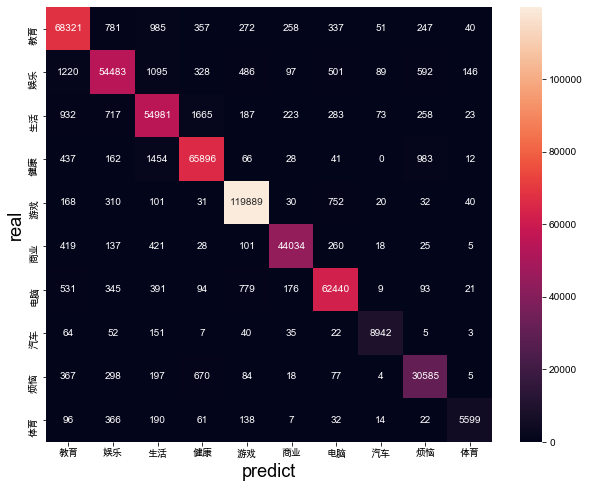

accuracy 0.9558629800466827
              precision    recall  f1-score   support

          教育       0.94      0.95      0.95     71649
          娱乐       0.95      0.92      0.93     59037
          生活       0.92      0.93      0.92     59342
          健康       0.95      0.95      0.95     69079
          游戏       0.98      0.99      0.99    121373
          商业       0.98      0.97      0.97     45448
          电脑       0.96      0.96      0.96     64879
          汽车       0.97      0.96      0.96      9321
          烦恼       0.93      0.95      0.94     32305
          体育       0.95      0.86      0.90      6525

    accuracy                           0.96    538958
   macro avg       0.95      0.94      0.95    538958
weighted avg       0.96      0.96      0.96    538958



In [88]:
start = time.time()
#训练模型
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.5, stratify=labels, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)

end = time.time()
print (end - start,'s')

plt.ylabel('real',fontsize=18)
plt.xlabel('predict',fontsize=18)
plt.show()
 
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat_id_df['cat'].values))